In [1]:
#Importing Libraries
#Data Handling
import pandas as pd
import numpy as np
import sklearn
import math
import random

import sys
sys.path.append('Write here the directory path of Code Supplementary Materil folder')

from source import *
import source.fairness as fm
import source.pipes as op
import source.utils as ut
from source.estimators import FORESEE

#Storing trains
import pickle

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


In [2]:
#Run following codes for loading pipelines on dictionary from pickles
with open('../../pipes/compas-recid/fairness/preprocessing.pickle', 'rb') as f:
    preprocessing_pickles = pickle.load(f)
    
with open('../../pipes/compas-recid/fairness/preprocessing_norm.pickle', 'rb') as f:
    preprocessing_pickles_norm = pickle.load(f)
    
with open('../../pipes/compas-recid/fairness/y.pickle', 'rb') as f:
    y = pickle.load(f)
    
with open('../../pipes/compas-recid/fairness/preprocessing_test.pickle', 'rb') as f:
    data_test_prepro = pickle.load(f)

with open('../../pipes/compas-recid/fairness/preprocessing_test_norm.pickle', 'rb') as f:
    data_test_prepro_norm = pickle.load(f)
    
with open('../../pipes/compas-recid/fairness/A.pickle', 'rb') as f:
    A = pickle.load(f)
    
with open('../../pipes/compas-recid/fairness/preprocessing_features_aware.pickle', 'rb') as f:
    aware_features = pickle.load(f)

with open('../../pipes/compas-recid/fairness/preprocessing_features_race.pickle', 'rb') as f:
    race_features = pickle.load(f)

In [3]:
#Run this for creating dictionary of datasets, nompipelines, and numpipelines
#remember: transf means data normalized and scaled.
datasets_prepro = {}
datasets_prepro_norm = {}
pipes_nominal = {}
pipes_numerical = {}
y_train = {}
y_test = {}
A_train = {}
A_test = {}

for p in preprocessing_pickles_norm:
    d , pnom, pnum = preprocessing_pickles_norm[p]
    datasets_prepro_norm[p] = d

for p in preprocessing_pickles:
    d , pnom, pnum = preprocessing_pickles[p]
    datasets_prepro[p] = d
    pipes_nominal[p] = pnom
    pipes_numerical[p] = pnum
    
for yval in y:
    if 'train' in yval:
        y_train[yval.replace('train_','')] = y[yval]
    if 'test' in yval:
        y_test[yval.replace('test_','')] = y[yval]
    
for Aval in A:
    if 'train' in Aval:
        A_train[Aval.replace('train_','')] = A[Aval]
    if 'test' in Aval:
        A_test[Aval.replace('test_','')] = A[Aval]
        
#Get in a dictionary all preprocessed datasets.
#Deberia llamarse datasets_train
datasets_train = {}
for d in datasets_prepro:
    ds = datasets_prepro[d]
    datasets_train[d] = ds
    
#Deberia llamarse datasets_norm_train
datasets_norm_train = {}
for d in datasets_prepro_norm:
    ds = datasets_prepro_norm[d]
    datasets_norm_train[d] = ds
    
#Get in a dictionary all preprocessed datasets.
datasets_test = {}
for d in data_test_prepro:
    ds = data_test_prepro[d]
    datasets_test[d] = ds
datasets_test.keys()

datasets_norm_test = {}
for d in data_test_prepro_norm:
    ds = data_test_prepro_norm[d]
    datasets_norm_test[d] = ds


In [10]:
sum(y_train['race']['two_year_recid'])/4317

0.46652768126013433

In [4]:
X_t  = datasets_train['race'].toarray()
A_t = np.array(A_train['race']['race'])
X_t_A = np.concatenate((X_t, 1*(A_t.reshape(-1,1)=='Caucasian')), axis=1)
y_t = np.array(y_train['race']['two_year_recid'])

In [15]:
fsee= FORESEE(min_samples_leaf=[2])
fsee.fit(X=X_t_A,
         A=A_t,
         priv_class='Caucasian',
         y=y_t,
         k=400,
         scoring=['accuracy'])

Complete                    

In [16]:
risks_train, disc_acc_train, count_disc_train = fsee.risk_disc(X=X_t_A,
                                                               y=y_t,
                                                               A=A_t,
                                                               priv_class='Caucasian', 
                                                               beta=0.57)


In [5]:
X_tt  = datasets_test['race'].toarray()
A_tt = np.array(A_test['race']['race'])
X_tt_A = np.concatenate((X_tt, 1*(A_tt.reshape(-1,1)=='Caucasian')), axis=1)
y_tt = np.array(y_test['race']['two_year_recid'])

In [18]:
risks_test, disc_acc_test, count_disc_test = fsee.risk_disc(X=X_tt_A,
                                                            y=y_tt,
                                                            A=A_tt,
                                                            priv_class='Caucasian', 
                                                            beta=0.57)


In [19]:
#checkpoints
with open('checkpoints/risks_train.pickle', 'wb') as f:
    pickle.dump(risks_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('checkpoints/risks_test.pickle', 'wb') as f:
    pickle.dump(risks_test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open('checkpoints/risks_train.pickle', 'rb') as f:
    risks_train = pickle.load(f)
    
with open('checkpoints/risks_test.pickle', 'rb') as f:
    risks_test = pickle.load(f)

# Analayzing Results

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns


In [107]:
risks_test['th_beta'].min()

0.3815844830160213

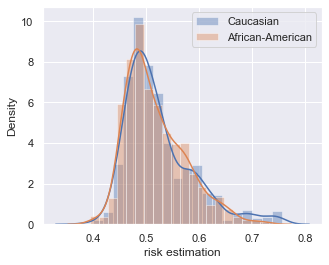

In [86]:
plt.figure(figsize=(5, 4))
sns.distplot(risks_test['th_beta'][A_tt=='Caucasian'], hist=True, kde=True, bins=20, label='Caucasian')
sns.distplot(risks_test['th_beta'][A_tt=='African-American'], hist=True, kde=True, bins=20, label='African-American')
plt.xlabel('risk estimation')
plt.legend()
plt.show()

# Models

In [29]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [7]:
#Obtain the X, Y and risk
X_train_models = datasets_norm_train['race'].toarray()
X_test_models = datasets_norm_test['race'].toarray()

In [24]:
parameters = {'LR__C':[0.01, 0.1, 1], 'LR__fit_intercept':[True, False], 'LR__solver': ['liblinear','lbfgs'], 'LR__class_weight': [None,'balanced'], 'LR__max_iter' : [100000]}
lr = LogisticRegression(random_state=0)
fit_lr = op.get_grid(X_train_models, y_t, parameters, lr, 'LR', scoring=['accuracy'], refit='accuracy')


In [25]:
parameters = {'RF__class_weight': ['balanced'],'RF__n_estimators':[10, 50, 100], 'RF__criterion': ['gini', 'entropy'], 'RF__max_depth': [None, 5, 10, 15]}
rf = RandomForestClassifier(random_state=0)

fit_rf = op.get_grid(X_train_models, y_t, parameters, rf, 'RF', scoring=['accuracy'], refit='accuracy')


In [26]:
parameters = {'KNN__weights': ['uniform', 'distance'],'KNN__n_neighbors': [5, 10, 15, 20, 25, 30]}
knn = KNeighborsClassifier()

fit_knn = op.get_grid(X_train_models, y_t, parameters, knn, 'KNN', scoring=['accuracy'], refit='accuracy')
        

In [27]:
parameters = {'SVM__probability':[True],'SVM__kernel':['rbf', 'sigmoid', 'poly'], 'SVM__C': [0.001, 0.01, 1, 10, 100], 'SVM__class_weight': [None,'balanced']}
svm = SVC(random_state=0)
fit_svm = op.get_grid(X_train_models, y_t, parameters, svm, 'SVM', scoring=['accuracy'], refit='accuracy')


In [28]:
models = {'LR': fit_lr,
          'RF': fit_rf,
          'KNN': fit_knn,
           'SVM': fit_svm}


In [24]:
models_results = pd.DataFrame(columns=['model','performance','eq_opp','eq_odd','dem_p'])

for m in models:
    clf = models[m].best_estimator_[m]
    y_pred = clf.predict(X_test_models)

    perfo = fm.accuracy(y_tt, y_pred)
    eq_opp = fm.equal_opp_dif(y_tt, y_pred, A_tt, 'Caucasian')
    eq_odd = fm.equalized_odd_dif(y_tt, y_pred, A_tt, 'Caucasian')
    dem_p = fm.demographic_parity_dif(y_pred, A_tt,'Caucasian')

    new_r = {'model': m,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results = models_results.append(new_r, ignore_index=True)
models_results

,model,performance,eq_opp,eq_odd,dem_p
0,LR,0.655210,0.221168,0.189726,0.213960
1,RF,0.668303,0.178221,0.174432,0.204852
2,KNN,0.650846,0.177925,0.167893,0.193510
3,SVM,0.655210,0.180223,0.170191,0.196691


In [30]:
with open('checkpoints/models.pickle', 'wb') as f:
    pickle.dump(models, f, protocol = pickle.HIGHEST_PROTOCOL)

In [8]:
with open('checkpoints/models.pickle', 'rb') as f:
    models = pickle.load(f)

In [10]:
fit_lr = models['LR']
fit_rf = models['RF']
fit_knn = models['KNN']
fit_svm = models['SVM']


# Using Risk for Training/Test, and Mitigation

## Using risky samples for training and test separately

In [100]:
threshold = .5#risks_train['total'].mean(where=False==np.isnan(risks_train['total']))+risks_train['total'].std(where=False==np.isnan(risks_train['total']))

X_train_high = X_train_models[risks_train['th_beta']>=threshold]
y_train_high = y_t[risks_train['th_beta']>=threshold]
A_train_high = A_t[risks_train['th_beta']>=threshold]

X_train_low = X_train_models[risks_train['th_beta']<threshold]
y_train_low = y_t[risks_train['th_beta']<threshold]
A_train_low = A_t[risks_train['th_beta']<threshold]

X_test_high = X_test_models[risks_test['th_beta']>=threshold]
y_test_high = y_tt[risks_test['th_beta']>=threshold]
A_test_high = A_tt[risks_test['th_beta']>=threshold]

X_test_low = X_test_models[risks_test['th_beta']<threshold]
y_test_low = y_tt[risks_test['th_beta']<threshold]
A_test_low = A_tt[risks_test['th_beta']<threshold]


In [101]:
models_results_both = pd.DataFrame(columns=['model','scenario','performance','eq_opp','eq_odd','dem_p'])
scenario = ['high','low']

for s in scenario:
    if s == 'high':
        X_test_model = X_test_high
        y_test_model = y_test_high
        A_test_model = A_test_high
    else:
        X_test_model = X_test_low
        y_test_model = y_test_low
        A_test_model = A_test_low
        
    clf =  models['RF'].best_estimator_['RF']
    y_pred = clf.predict(X_test_model)

    perfo = fm.accuracy(y_test_model, y_pred)
    eq_opp = fm.equal_opp_dif(y_test_model, y_pred, A_test_model, 'Caucasian')
    eq_odd = fm.equalized_odd_dif(y_test_model, y_pred, A_test_model, 'Caucasian')
    dem_p = fm.demographic_parity_dif(y_pred, A_test_model,'Caucasian')

    new_r = {'model': 'RF',
             'scenario': s,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results_both = models_results_both.append(new_r, ignore_index=True)
models_results_both

,model,scenario,performance,eq_opp,eq_odd,dem_p
0,RF,high,0.705703,0.306100,0.203604,0.222216
1,RF,low,0.625147,0.077193,0.161629,0.174389


## Mitigation

### Removing risky samples from dataset
So not risky in training neither testing

In [102]:
rf = RandomForestClassifier(random_state=0)
parameters = {'RF__class_weight': ['balanced'],'RF__n_estimators':[10, 50, 100], 'RF__criterion': ['gini', 'entropy'], 'RF__max_depth': [None, 5, 10, 15]}

fit_rf_low = op.get_grid(X_train_low, y_train_low, parameters, rf, 'RF', scoring=['accuracy'], refit='accuracy')


In [103]:
fit_rf = models['RF']

In [104]:
models_scenario = {'overall': fit_rf, 'rem_high':fit_rf_low, 'rem_high_test':fit_rf}

models_results_rem = pd.DataFrame(columns=['model','scenario','performance','eq_opp','eq_odd','dem_p'])
scenario = ['overall','rem_high', 'rem_high_test']

for s in scenario:
    if s == 'overall':
        X_test_model = X_test_models
        y_test_model = y_tt
        A_test_model = A_tt
    else:
        X_test_model = X_test_low
        y_test_model = y_test_low
        A_test_model = A_test_low
        
    clf = models_scenario[s].best_estimator_['RF']
    y_pred = clf.predict(X_test_model)

    perfo = fm.accuracy(y_test_model, y_pred)
    eq_opp = fm.equal_opp_dif(y_test_model, y_pred, A_test_model, 'Caucasian')
    eq_odd = fm.equalized_odd_dif(y_test_model, y_pred, A_test_model, 'Caucasian')
    dem_p = fm.demographic_parity_dif(y_pred, A_test_model,'Caucasian')

    new_r = {'model': 'RF',
             'scenario': s,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results_rem = models_results_rem.append(new_r, ignore_index=True)
models_results_rem

,model,scenario,performance,eq_opp,eq_odd,dem_p
0,RF,overall,0.668303,0.178221,0.174432,0.204852
1,RF,rem_high,0.578143,0.133788,0.148728,0.158301
2,RF,rem_high_test,0.625147,0.077193,0.161629,0.174389


### Implementing post-processing approahces

In [43]:
from fairlearn.postprocessing import ThresholdOptimizer

RF_best = fit_rf.best_estimator_['RF']

postprocess_est_eqODD = ThresholdOptimizer(
    estimator=RF_best,
    constraints="equalized_odds",
    objective = 'balanced_accuracy_score',
    prefit=False,
    flip=True)

postprocess_est_demP = ThresholdOptimizer(
    estimator=RF_best,
    constraints="demographic_parity",
    objective = 'balanced_accuracy_score',
    prefit=False,
    flip=True)

postprocess_est_eqOPP = ThresholdOptimizer(
    estimator=RF_best,
    constraints="true_positive_rate_parity",
    objective = 'balanced_accuracy_score',
    prefit=False,
    flip=True)

In [44]:
postprocess_est_eqODD.fit(X_train_models, y_t, sensitive_features=A_t)
postprocess_est_demP.fit(X_train_models, y_t, sensitive_features=A_t)
postprocess_est_eqOPP.fit(X_train_models, y_t, sensitive_features=A_t)


ThresholdOptimizer(constraints='true_positive_rate_parity',
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    criterion='entropy',
                                                    max_depth=5,
                                                    n_estimators=50,
                                                    random_state=0),
                   flip=True, objective='balanced_accuracy_score')

In [97]:
post_processings = {'dem_p': postprocess_est_demP,
                    'eq_odd': postprocess_est_eqODD,
                    'eq_opp': postprocess_est_eqOPP}

models_results_post = pd.DataFrame(columns=['model','scenario','performance','eq_opp','eq_odd','dem_p'])
scenario = ['dem_p','eq_odd', 'eq_opp']

for s in scenario:
    clf = post_processings[s]
    y_pred = clf.predict(X_test_models, sensitive_features=A_tt, random_state=1)

    perfo = fm.f1score(y_tt, y_pred)
    eq_opp = fm.equal_opp_dif(y_tt, y_pred, A_tt, 'Caucasian')
    eq_odd = fm.equalized_odd_dif(y_tt, y_pred, A_tt, 'Caucasian')
    dem_p = fm.demographic_parity_dif(y_pred, A_tt,'Caucasian')

    new_r = {'model': 'RF',
             'scenario': s,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results_post = models_results_post.append(new_r, ignore_index=True)
models_results_post

,model,scenario,performance,eq_opp,eq_odd,dem_p
0,RF,dem_p,0.641791,0.027396,0.049098,0.000201
1,RF,eq_odd,0.480811,-0.237318,0.128993,-0.097430
2,RF,eq_opp,0.633300,-0.096765,0.204472,-0.193524


We now apply only to the high risky set

In [105]:
postprocess_est_eqODD.fit(X_train_high, y_train_high, sensitive_features=A_train_high)
postprocess_est_demP.fit(X_train_high, y_train_high, sensitive_features=A_train_high)
postprocess_est_eqOPP.fit(X_train_high, y_train_high, sensitive_features=A_train_high)


ThresholdOptimizer(constraints='true_positive_rate_parity',
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    criterion='entropy',
                                                    max_depth=5,
                                                    n_estimators=50,
                                                    random_state=0),
                   flip=True, objective='balanced_accuracy_score')

In [106]:
post_processings = {'dem_p': postprocess_est_demP,
                    'eq_odd': postprocess_est_eqODD,
                    'eq_opp': postprocess_est_eqOPP}

models_results_post_focus = pd.DataFrame(columns=['model','scenario','performance','eq_opp','eq_odd','dem_p'])
scenario = ['dem_p','eq_odd', 'eq_opp']

for s in scenario:
    clf_post = post_processings[s]
    clf = models['RF'].best_estimator_['RF']
    
    y_pred_post = clf_post.predict(X_test_high, 
                              sensitive_features=A_test_high, 
                              random_state=1)
    y_pred_low = clf.predict(X_test_low)
    y_pred_f = np.concatenate((y_pred_post, y_pred_low))
    
    y_test_f = np.concatenate((y_test_high, y_test_low))
    A_test_f = np.concatenate((A_test_high, A_test_low))
    
    perfo = fm.f1score(y_test_f, y_pred_f)
    eq_opp = fm.equal_opp_dif(y_test_f, y_pred_f, A_test_f, 'Caucasian')
    eq_odd = fm.equalized_odd_dif(y_test_f, y_pred_f, A_test_f, 'Caucasian')
    dem_p = fm.demographic_parity_dif(y_pred_f, A_test_f,'Caucasian')

    new_r = {'model': 'RF',
             'scenario': s,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results_post_focus = models_results_post_focus.append(new_r, ignore_index=True)
models_results_post_focus

,model,scenario,performance,eq_opp,eq_odd,dem_p
0,RF,dem_p,0.630243,0.064375,0.054459,0.030680
1,RF,eq_odd,0.563144,-0.022341,0.065520,0.073938
2,RF,eq_opp,0.627492,-0.026229,0.112397,-0.097560


# Profiles

In [108]:
aware_dataset = pd.DataFrame(data_test_prepro['race'].toarray(), columns=race_features)
race_dataset = pd.DataFrame(1*(A_tt=='Caucasian'), columns=['race']) #if 1, then Caucasian
risk_dataset = pd.DataFrame(risks_test['th_beta'], columns=['risk'])
label_dataset = pd.DataFrame(y_tt, columns = ['label'])
bins = pd.DataFrame(np.zeros((y_tt.shape[0])), columns = ['bins'])
profile_dataset = pd.concat([aware_dataset, race_dataset, risk_dataset, label_dataset, bins], axis=1)
#Scaled and standardize all variables
for i in range(len(profile_dataset.columns)-4):
    profile_dataset.iloc[:,i]=(profile_dataset.iloc[:,i]-profile_dataset.iloc[:,i].mean())/(profile_dataset.iloc[:,i].std())
     
profile_dataset

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_days_jail,sex,age_cat,c_charge_degree,race,risk,label,bins
0,-0.972382,-0.163605,-0.172063,-0.252707,-0.738268,-0.309693,0.501056,1.649214,-0.736636,0,0.521294,0,0.0
1,-1.056742,-0.163605,-0.172063,-0.252707,-0.119123,0.331377,0.501056,1.649214,-0.736636,0,0.510797,0,0.0
2,0.039948,-0.163605,-0.172063,-0.252707,0.500023,-0.329727,0.501056,-0.803532,-0.736636,0,0.464759,0,0.0
3,-0.719299,-0.163605,1.532760,-0.252707,1.325550,-0.309693,0.501056,-0.803532,-0.736636,0,0.519698,1,0.0
4,-1.225464,-0.163605,3.237583,1.911833,-0.119123,-0.329727,-1.994695,1.649214,1.356781,1,0.416429,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1828,-1.141103,-0.163605,-0.172063,-0.252707,-0.531886,-0.309693,0.501056,1.649214,-0.736636,0,0.515901,1,0.0
1829,-0.634938,-0.163605,-0.172063,-0.252707,-0.325504,-0.329727,-1.994695,-0.803532,1.356781,0,0.507447,1,0.0
1830,-0.719299,-0.163605,-0.172063,-0.252707,-0.738268,-0.169459,0.501056,-0.803532,1.356781,1,0.574716,0,0.0
1831,-1.141103,2.865573,3.237583,4.076373,-0.119123,-0.329727,0.501056,1.649214,-0.736636,0,0.430831,1,0.0


In [109]:
np.unique(profile_dataset['sex'], return_counts=True)

(array([-1.99469457,  0.50105638]), array([ 368, 1465]))

In [110]:
profile_dataset = profile_dataset.iloc[:,np.where(profile_dataset.columns!='age_cat')[0]]

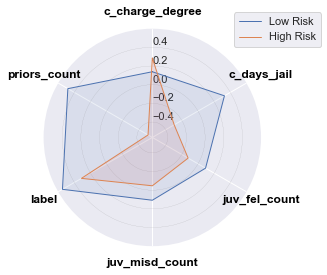

In [111]:
#Plot
numbers_features = 6
features = profile_dataset.columns
bins =5
priv = 1
sens_attr = 'race'
ascending = True


profile_dataset_result, ds_radarchart_result, categories = ut.plotProfiles(profile_dataset=profile_dataset, 
                                                 numbers_features=numbers_features, 
                                                 features=features, 
                                                 bins=bins, 
                                                 priv=priv, 
                                                 sens_attr=sens_attr, 
                                                 ascending=ascending)

In [48]:
ds_radarchart_result

,age,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,sex
bins,,,,,,,
1.0,-0.418043,-0.076420,-0.130500,-0.139458,-0.140340,-0.225133,0.228297
2.0,0.022431,-0.116629,-0.080841,-0.116168,-0.016145,-0.008601,0.051003
3.0,0.009984,0.017401,0.035029,-0.060272,-0.033887,0.043276,-0.030825
4.0,0.017821,0.101169,0.092964,0.107416,0.084394,0.203419,-0.078558
5.0,0.364817,0.073873,0.082669,0.206786,0.105117,-0.012856,-0.168535


In [49]:
pd.pivot_table(profile_dataset_result, values=['race'], index=['bins'])

,race
bins,
1.0,0.398907
2.0,0.398907
3.0,0.398907
4.0,0.398907
5.0,0.403794
